<a href="https://colab.research.google.com/github/Ananya-AJ/CMPE255-SafeDose/blob/main/Models_Casetype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---

**This colab implements Multiclass classification algorithms to determine the type of case for those that are marked as 'Others' in the original dataset. The aim is to overcome the limitations of manually determining the type of case  due to incomplete/ explicit documentation of substance abuse. Several algorithms are tried and tested for performance, finally selecting the RandomForestCalssifier for predicting on the test set.**


---


In [1]:
# Import libraries
from google.colab import drive
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt  

from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report, precision_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


### Import data

In [3]:
# Read train and test data
c_train = pd.read_csv('/content/drive/Shareddrives/CMPE255/data/dimensionality_reduction/X_train_casetype.csv')
c_test = pd.read_csv('/content/drive/Shareddrives/CMPE255/data/dimensionality_reduction/X_test_casetype.csv')
c_train = c_train.iloc[:, 1:]
c_test = c_test.iloc[:, 1:]

columns = ['CASETYPE_1', 'CASETYPE_2', 'CASETYPE_3', 'CASETYPE_4', 'CASETYPE_5', 'CASETYPE_6', 'CASETYPE_7']

# Get X and y from train and test
c_X_train = c_train.drop(columns, axis = 1)
c_y_train = c_train[columns]

X_test = c_test.drop(['CASETYPE_8'], axis = 1)

# Reverse one hot encoding on casetype
c_y_train['target'] = pd.get_dummies(c_y_train[columns]).idxmax(1)
c_y_train.drop(columns, axis = 1, inplace = True)

<ipython-input-3-0bbf0ffaeb6c>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  c_y_train['target'] = pd.get_dummies(c_y_train[columns]).idxmax(1)
/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [4]:
# Check the target class counts
c_y_train.target.value_counts()

CASETYPE_4    85777
CASETYPE_5    16810
CASETYPE_2    13529
CASETYPE_1     7872
CASETYPE_3     7421
CASETYPE_7     3125
CASETYPE_6      768
Name: target, dtype: int64

Performing SMOTE (Synthetic Minority Oversampling Technique) due to the class imbalance of CASETYPE. Oversampling ensures that they are near equal number of records for every CASETYPE which prevents bias towards the majority class and reduces possibility of poor classification of the minority classes.

### Oversample using SMOTE

In [5]:
# SMOTE
sm = SMOTE(random_state = 42)
X_smote, y_smote = sm.fit_resample(c_X_train, c_y_train)

In [6]:
# Split train into train and validation set
X_train, X_val, y_train, y_val = train_test_split(X_smote, y_smote, test_size = 0.2, shuffle = True, stratify = y_smote, random_state = 42)

In [7]:
print('Shape before oversampling')
print('X_train = ', c_X_train.shape)

print('Shape after oversampling and splitting into train and validation sets')
print('X_train = ', X_train.shape)
print('X_val = ', X_val.shape)

Shape before oversampling
X_train =  (135302, 39)
Shape after oversampling and splitting into train and validation sets
X_train =  (480351, 39)
X_val =  (120088, 39)


In [8]:
y_train.target.value_counts()

CASETYPE_1    68622
CASETYPE_6    68622
CASETYPE_3    68622
CASETYPE_2    68622
CASETYPE_4    68621
CASETYPE_5    68621
CASETYPE_7    68621
Name: target, dtype: int64

The target classes in the training set are now balanced.

In [9]:
# Create dictionary to store best parameter set and f1 score obtained from every model
models = ['NaiveBayes', 'LogisticRegression', 'LightGBM', 'RandomForest', 'KneighborsClassifier']
model_performance = {k:{} for k in models}

### Naive Bayes

In [10]:
# Naive Bayes Classifier
nb = GaussianNB()
nb.fit(X_train, y_train)

# Predcit on validation set
y_pred_val = nb.predict(X_val)

# Calculate precision on validation set
f1 = f1_score(y_val, y_pred_val, average = 'macro')
precision = precision_score(y_val, y_pred_val, average = 'macro')

# Save metrics to dictionary
model_performance['NaiveBayes'] = {'prec':precision, 'f1':f1}

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Logistic Regression

In [11]:
# Logistic Regression
lr = LogisticRegression()
lr.fit(X_train, y_train)

# Predict on validation set
y_pred_val = lr.predict(X_val)

# Calculate precision and f1 score on validation set
f1 = f1_score(y_val, y_pred_val, average = 'macro')
precision = precision_score(y_val, y_pred_val, average = 'macro')

# Save metrics to dictionary
model_performance['LogisticRegression'] = {'prec':precision, 'f1':f1}

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### KNN

In [ ]:
# KneighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 4, n_jobs = -1)
knn.fit(X_train, y_train)

# Predict on validation set
y_pred_val = knn.predict(X_val)

# Calculate precision and f1 score on validation set
f1 = f1_score(y_val, y_pred_val, average = 'macro')
precision = precision_score(y_val, y_pred_val, average = 'macro')

# Save metrics in dictionary
model_performance['KneighborsClassifier'] = {'prec':precision, 'f1':f1}

### Light GBM

In [12]:
# LightGBM
gbc = LGBMClassifier(n_estimators = 100, learning_rate = 0.01, max_depth = 5, random_state = 11)
gbc.fit(X_train, y_train.values.ravel())

# Predict on validation
y_pred_val = gbc.predict(X_val)

# Calculate precision and f1 score on validation set
precision = precision_score(y_val, y_pred_val, average = 'macro')
f1 = f1_score(y_val, y_pred_val, average = 'macro')

# Store metrics in dict
model_performance['LightGBM'] = {'prec':precision, 'f1':f1}

### Random Forest

In [13]:
# Random Forest Classifier
forest = RandomForestClassifier(n_estimators = 10, min_samples_leaf = 1, min_samples_split = 2, random_state = 1)
multi_target_forest = MultiOutputClassifier(forest, n_jobs = -1)

# Fit on train set
multi_target_forest.fit(X_train, y_train)

# Predict on validation
y_pred_val = multi_target_forest.predict(X_val)

# Calculate precision and f1 score on validation set
f1 = f1_score(y_val, y_pred_val, average = 'macro')
precision = precision_score(y_val, y_pred_val, average = 'macro')

# Store in dict
model_performance['RandomForest'] = {'prec':precision, 'f1':f1}

### Choose best performing model

 In predicting casetypes, precision is an important metric as the type of case would determine the next steps of treatment for the patient. Precision score tells us out of the predicted true/positive cases, how many were actually true/ positive for that particular casetype. Recall should also be considered as it is important that out of the actual positive case of each casetype, how many were correctly identified, which is given by recall. However, precision is more significant in our case, and hence precision is the primary metric and F1 score is the secondary metric.

In [14]:
# Determine the best performing model from the model_performance dictionary
model_performance

{'NaiveBayes': {'prec': 0.7597630201738594, 'f1': 0.7540000321683821},
 'LogisticRegression': {'prec': 0.8170836211760693, 'f1': 0.8177302580525124},
 'LightGBM': {'prec': 0.808815577337722, 'f1': 0.8067369922688045},
 'RandomForest': {'prec': 0.9690990223091378, 'f1': 0.9688343677819456},
 'KneighborsClassifier': {}}

###  Prediction on validation set using the chosen model, and metrics

In [15]:
# Predict on validation
y_pred_val = multi_target_forest.predict(X_val)

# Prediction on test set
y_pred_test = multi_target_forest.predict(X_test)

In [16]:
# Create dataframes for predicted casetype and actual casetype
predictions_test = pd.DataFrame(list(y_pred_test), columns = ['PRED_CASETYPE'])
predictions_val = pd.DataFrame(list(y_pred_val), columns = ['PRED_CASETYPE'])

casetypes = {
    'CASETYPE_1' : 'Suicide Attempt',
    'CASETYPE_2' : 'Seeking Detox',
    'CASETYPE_3' : 'Alcohol consumed below 21 years',
    'CASETYPE_4' : 'Adverse Reaction',
    'CASETYPE_5' : 'Overmedication',
    'CASETYPE_6' : 'Malicious Poisoning',
    'CASETYPE_7': 'Accidental Ingestion'
}

# Map casetype number to casetype name
predictions_test['PRED_CASETYPE'] = predictions_test['PRED_CASETYPE'].map(casetypes)
predictions_val['PRED_CASETYPE'] = predictions_val['PRED_CASETYPE'].map(casetypes)

y_val['target'] = y_val['target'].map(casetypes)

This is the classifciation of the casetypes of the 'other' category. Since the target casetypes are unavailable, we look at the precision and f1 score on the validation set.

In [18]:
# Classification  report
print(classification_report(y_val, predictions_val))

                                 precision    recall  f1-score   support

           Accidental Ingestion       0.98      0.98      0.98     17156
               Adverse Reaction       0.95      0.90      0.92     17156
Alcohol consumed below 21 years       1.00      1.00      1.00     17155
            Malicious Poisoning       0.99      1.00      1.00     17155
                 Overmedication       1.00      0.99      1.00     17156
                  Seeking Detox       0.96      0.96      0.96     17155
                Suicide Attempt       0.91      0.95      0.93     17155

                       accuracy                           0.97    120088
                      macro avg       0.97      0.97      0.97    120088
                   weighted avg       0.97      0.97      0.97    120088



In [29]:
# Confusion matrix 

cm = confusion_matrix(y_val, predictions_val)
labels = ['Accidental Ingestion', 'Adverse Reaction', 'Alcohol consumed below 21 years', 'Malicious Poisoning', 'Overmedication', 'Seeking Detox', 'Suicide Attempt']

([<matplotlib.axis.YTick at 0x7fab63adb6d0>,
 [Text(0, 0.5, 'Accidental Ingestion'),
  Text(0, 1.5, 'Adverse Reaction'),
  Text(0, 2.5, 'Alcohol consumed below 21 years'),
  Text(0, 3.5, 'Malicious Poisoning'),
  Text(0, 4.5, 'Overmedication'),
  Text(0, 5.5, 'Seeking Detox'),
  Text(0, 6.5, 'Suicide Attempt')])

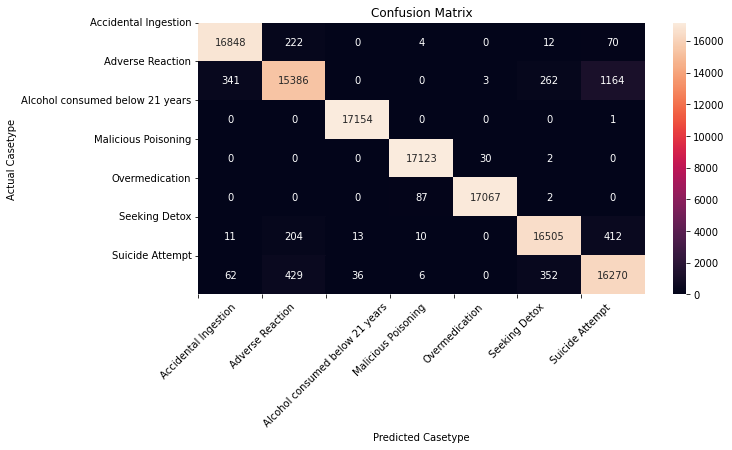

In [37]:
# PLot confusion matrix as a heatmap

plt.figure(figsize = (10,5))
sns.heatmap(cm, annot = True, fmt = 'g')
plt.xlabel('Predicted Casetype')
plt.ylabel('Actual Casetype')
plt.title('Confusion Matrix')

x = [0,1,2,3,4,5,6]

plt.xticks(x, labels, rotation = 45)
plt.yticks(x, labels, rotation = 'horizontal')

Overall, the random forest classifier is able to distinguish between the casetypes quite well. However, it seems to misclassify 'Adverse Reaction' as 'Suicide Attempt' in a large number of cases. 